In [1]:
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup
from bs4 import Comment
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import scipy.stats as st
import re
from openpyxl import load_workbook

### Create data frame with list of all NBA teams

In [2]:
html = urlopen('https://www.basketball-reference.com/teams/')
html_read = html.read()
bsObj = BeautifulSoup(html_read)

team_abbrev = []
team_name = []
for child in bsObj.find('tbody').children:
    try:
        team_url = child.find('a').get('href')
        team = re.split('/', team_url)[2]
        team_abbrev.append(team)
        
        name = child.find('th').get_text()
        team_name.append(name)
    except:
        pass
    
df_teams = pd.DataFrame({'team':team_abbrev, 'name':team_name})

# fix abbreviation for teams with new abbreviations in 2021 season
df_teams.iloc[2][0] = 'BRK'
df_teams.iloc[18][0] = 'NOP'
df_teams.iloc[3][0] = 'CHO'

df_teams.to_csv('df_teams.csv')

### create data frame with list of all players on 2021 NBA rosters

In [3]:
df_players = pd.DataFrame(columns = ['team_name', 'team_code', 'player_name', 'player_code'])
codes = []
names = []
for i in range(len(df_teams)):
    team = df_teams.iloc[i,0]
    name = df_teams.iloc[i,1]
    team_url = urlopen('https://www.basketball-reference.com/teams/' + team + '/2021.html')
    bsObj = BeautifulSoup(team_url.read())
    for child in bsObj.find('tbody').children:
        try:
            player_url = child.find('a').get('href')            
            player_name = child.find('a').get_text()  
            player_url = re.split('\.', player_url)[0]
            player_code = re.split('/', player_url)[3]
            player_code = '/' + player_code[0] + '/' + player_code
            codes.append(player_code)
            names.append(player_name)
        except:
            pass
    df_team = pd.DataFrame(zip([name] * len(codes), [team] * len(codes), names, codes), 
                           columns=['team_name', 'team_code', 'player_name', 'player_code'])
    df_players = pd.concat([df_players, df_team], join='outer')
    codes = []
    names = []

df_players = df_players.reset_index(drop=True)

# brazdig01 is repeated twice so delete one of them (also the link doesnt work so delete both)
df_players.drop(labels=371, inplace=True)
df_players.drop(labels=372, inplace=True)

df_players.to_csv('df_players.csv')

df_players.head()

,team_name,team_code,player_name,player_code
0,Atlanta Hawks,ATL,Solomon Hill,/h/hillso01
1,Atlanta Hawks,ATL,Kevin Huerter,/h/huertke01
2,Atlanta Hawks,ATL,Trae Young,/y/youngtr01
3,Atlanta Hawks,ATL,John Collins,/c/collijo01
4,Atlanta Hawks,ATL,Clint Capela,/c/capelca01


# Web scrape player data from basketballreference.com

In [4]:
def get_stats_month(month, df_stats_1, df_stats_2, df_stats_3, df_stats_4):
    columns_basic = ['player_name', 'min', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
                     'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-', 'team_name', 'opp_name', 'home', 'date',
                     'team_abbrev', 'team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg',
                     'opp_abbrev', 'opp_Pace', 'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg'
                    ]
    columns_advanced = ['player_name', 'min', 'TS%', 'eFG%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
                        'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'BPM', 'team_name', 'opp_name', 'home', 'date'
                       ]   
    month_url = urlopen('https://www.basketball-reference.com/leagues/NBA_2021_games-{}.html'.format(month))
    month_bsObj = BeautifulSoup(month_url.read())
    for game in month_bsObj.find('tbody').children:
        try:
            date = game.find('th').get_text()
            date = pd.to_datetime(date)
            
            team1 = game.find_all('td')[1].get_text()
            team2 = game.find_all('td')[3].get_text()
            
            box_score_url = game.find_all('a')[3].get('href')
            box_score_url = urlopen('https://www.basketball-reference.com{}'.format(box_score_url))
            box_score_bsObj = BeautifulSoup(box_score_url.read())
            
            ###### Four factors for teams
            four_factors = box_score_bsObj.find('div', attrs={'id': ['all_four_factors']})
            for comment in four_factors(text=lambda text: isinstance(text, Comment)):
                comment = BeautifulSoup(comment, 'html.parser')
                team1_stats = []
                team2_stats = []
                flag=0
                table = comment.find('tbody')
                for team in table.children:
                    try:
                        for stat in team.children:
                            if flag == 0:
                                team1_stats.append(stat.get_text())
                            else:
                                team2_stats.append(stat.get_text())
                        flag = 1
                    except:
                        pass
            
            ###### There are four tables of interest for players
            divs = box_score_bsObj.find_all('div', attrs={'class':'table_container'})
            caption = ''
            for div in divs:
                try:
                    prev_caption = caption
                    caption = div.caption.get_text()
                    # One
                    if re.search('{} \([0-9]'.format(team1), caption):
                        table = div.find('tbody')
                        for child in table.children:
                            try:
                                stats = []
                                for stat in child.children:
                                    stats.append(stat.get_text())
                                stats.append(team1)
                                stats.append(team2)
                                stats.append(0)
                                stats.append(date)
                                stats = np.concatenate([stats, team1_stats, team2_stats])
                                df_stats_1 = df_stats_1.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns = columns_basic))
                            except:
                                pass
                
                    # Two
                    if re.search('{} \([0-9]'.format(team2), caption):
                        table = div.find('tbody')
                        for child in table.children:
                            try:
                                stats = []
                                for stat in child.children:
                                    stats.append(stat.get_text())
                                stats.append(team2)
                                stats.append(team1)
                                stats.append(1)
                                stats.append(date)
                                stats = np.concatenate([stats, team2_stats, team1_stats])
                                df_stats_2 = df_stats_2.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns = columns_basic))
                            except:
                                pass
                    
                    # Three
                    if re.search('^ Table$', caption) and (team1 in prev_caption):
                        table = div.find('tbody')
                        for child in table.children:
                            try:
                                stats = []
                                for stat in child.children:
                                    stats.append(stat.get_text())
                                stats.append(team1)
                                stats.append(team2)
                                stats.append(0)
                                stats.append(date)
                                df_stats_3 = df_stats_3.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns = columns_advanced))
                            except:
                                pass
                
                    # Four
                    if re.search('^ Table$', caption) and (team2 in prev_caption):
                        table = div.find('tbody')
                        for child in table.children:
                            try:
                                stats = []
                                for stat in child.children:
                                    stats.append(stat.get_text())
                                stats.append(team2)
                                stats.append(team1)
                                stats.append(1)
                                stats.append(date)
                                df_stats_4 = df_stats_4.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns = columns_advanced)) 
                            except:
                                pass
                except:
                    pass
        except:
            pass
    
    return df_stats_1, df_stats_2, df_stats_3, df_stats_4


- the following cell only needs to be run once to collect data from previous months then save to csv
- then, run the next cell daily to retrieve data on previous day's games (by retrieving current month's data)

In [ ]:
months = ['december', 'january', 'february', 'march', 'april']
df_stats_1 = pd.DataFrame()
df_stats_2 = pd.DataFrame()
df_stats_3 = pd.DataFrame()
df_stats_4 = pd.DataFrame()

for month in months:
    df_stats_1, df_stats_2, df_stats_3, df_stats_4 = get_stats_month(month, df_stats_1, df_stats_2, df_stats_3, df_stats_4)
    print(month)

df_stats_1.to_csv('df_stats_1.csv')
df_stats_2.to_csv('df_stats_2.csv')
df_stats_3.to_csv('df_stats_3.csv')
df_stats_4.to_csv('df_stats_4.csv')

# Run code for current month

In [300]:
# since it is currently May, games are added to to the website on May each day so re-run this code daily
# when it switches to June, add May to the previous cell and run this cell for June
df_stats_1 = pd.read_csv('df_stats_1.csv', index_col=0)
df_stats_2 = pd.read_csv('df_stats_2.csv', index_col=0)
df_stats_3 = pd.read_csv('df_stats_3.csv', index_col=0)
df_stats_4 = pd.read_csv('df_stats_4.csv', index_col=0)

MONTH = 'may'

df_stats_1, df_stats_2, df_stats_3, df_stats_4 = get_stats_month(MONTH, df_stats_1, df_stats_2, df_stats_3, df_stats_4)

# Merge data frames

In [301]:
df_stats_basic = pd.concat([df_stats_1, df_stats_2])
df_stats_advanced = pd.concat([df_stats_3, df_stats_4])

df_stats = pd.merge(df_stats_basic, df_stats_advanced, how='inner', 
                    on=['player_name', 'min', 'team_name', 'opp_name', 'home', 'date'])

# get rid of unnecessary columns
df_stats.drop(columns=['FG%', '3P%', 'FT%', 'TRB'], inplace=True)
                        
df_stats.head()

,player_name,min,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,...,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM
0,Andrew Wiggins,31:14,4,16,2,6,3,4,0,2,...,6.5,3,5,0,2.7,18.4,26.3,63,118,-14
1,Stephen Curry,30:19,7,21,2,10,4,4,3,1,...,3.4,6.1,61.1,2.9,0,11.6,32.1,99,114,6
2,Kelly Oubre,25:39,3,14,0,6,0,0,4,3,...,11.9,12.6,11.9,1.7,6.6,17.6,25,54,110,-11
3,James Wiseman,24:17,7,13,1,1,4,8,1,5,...,21,11.4,0,3.6,0,5.7,27.2,107,107,3.3
4,Eric Paschall,21:33,2,6,1,1,1,2,1,0,...,0,2.1,0,0,3.9,0,12.1,96,119,-6.9


# Data Cleaning

In [302]:
df_clean = df_stats.copy()

# convert columns with numbers to numeric type
numeric_columns = ['FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB','DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-',
                   'home', 'team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg','opp_Pace', 
                   'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg', 'TS%', 'eFG%', '3PAr', 'FTr', 'ORB%', 
                   'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'BPM']
for column in numeric_columns:
    df_clean[column] = pd.to_numeric(df_clean[column])

# convert min from string to numeric
def min_to_numeric(value):
    minute = int(re.split(':', value)[0])
    second = int(re.split(':', value)[1])
    return minute + round(second / 60, 2)
df_clean['min'] = df_clean['min'].apply(lambda x: min_to_numeric(x))

# convert date to datetime
df_clean['date'] = pd.to_datetime(df_clean['date'])

# only consider players who played for at least 25 min
# I am not interested in making predictions for low-scoring players
df_clean = df_clean[df_clean['min'] >= 25]

df_clean.head()

,player_name,min,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,...,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM
0,Andrew Wiggins,31.23,4,16,2,6,3,4,0,2,...,6.5,3.0,5.0,0.0,2.7,18.4,26.3,63.0,118.0,-14.0
1,Stephen Curry,30.32,7,21,2,10,4,4,3,1,...,3.4,6.1,61.1,2.9,0.0,11.6,32.1,99.0,114.0,6.0
2,Kelly Oubre,25.65,3,14,0,6,0,0,4,3,...,11.9,12.6,11.9,1.7,6.6,17.6,25.0,54.0,110.0,-11.0
13,Paul George,35.77,13,18,5,8,2,2,0,6,...,21.8,9.5,15.2,1.3,0.0,20.9,27.3,131.0,107.0,10.9
14,Kawhi Leonard,34.02,10,26,1,8,5,5,0,2,...,7.6,3.3,14.2,2.7,0.0,9.6,37.5,93.0,106.0,-5.6


# Create dataset with following data:
- player stats averaged over season up until game of interest
- player stats averaged over the last week
- team/opp stats averaged over season up until game of interest
- team/opp stats averaged over the last week


In [303]:
df_final = df_clean[['player_name', 'team_name', 'opp_name', 'home', 'date', 'PTS']].copy()

# only consider games starting in January so that we have at least a week of games already played
df_final = df_final[df_final['date'] >= pd.to_datetime('2021-01-01')]

# add player stats averaged over the last week
def player_week(row):
    player = row['player_name']
    team = row['team_name']
    date = row['date']
    df_player = df_clean[df_clean['player_name'] == player]
    df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
    if len(df_player_week) == 0:
        col = df_player.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).columns
        AVGs = pd.Series(np.zeros(len(df_stats.columns) - 6), index=col)
    else:
        AVGs = df_player_week.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).mean()
    return AVGs

def player_season(row):
    player = row['player_name']
    team = row['team_name']
    date = row['date']
    df_player = df_clean[df_clean['player_name'] == player]
    df_player_season = df_player[df_player['date'] < date]
    if len(df_player_season) == 0:
        col = df_player.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).columns
        AVGs = pd.Series(np.zeros(len(df_stats.columns) - 6), index=col)
    else:
        AVGs = df_player_season.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).mean()
    return AVGs

def opp_week(row):
    player = row['player_name']
    opp = row['opp_name']
    date = row['date']
    df_opp = df_clean[df_clean['team_name'] == opp]
    df_opp = df_opp[['date','team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg', 
                     'opp_Pace', 'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg']]
    df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
    if len(df_opp_week) == 0:
        col = df_opp_week.drop(columns=['date']).columns
        AVGs = pd.Series(np.zeros(len(df_opp.columns) - 1), index=col)
    else:
        df_opp_week = df_opp_week.groupby(by='date').agg(np.mean)
        AVGs = df_opp_week.mean()
    return AVGs
        
def opp_season(row):
    player = row['player_name']
    opp = row['opp_name']
    date = row['date']
    df_opp = df_clean[df_clean['team_name'] == opp]
    df_opp = df_opp[['date','team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg', 
                     'opp_Pace', 'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg']]
    df_opp_season = df_opp[df_opp['date'] < date]
    if len(df_opp_season) == 0:
        col = df_opp_season.drop(columns=['date']).columns
        AVGs = pd.Series(np.zeros(len(df_opp.columns) - 1), index=col)
    else:
        df_opp_season = df_opp_season.groupby(by='date').agg(np.mean)
        AVGs = df_opp_season.mean()
    return AVGs
    
df_player_week = df_final.apply(lambda x: player_week(x), axis=1)
df_player_season = df_final.apply(lambda x: player_season(x), axis=1)
df_opp_week = df_final.apply(lambda x: opp_week(x), axis=1)
df_opp_season = df_final.apply(lambda x: opp_week(x), axis=1)

df_final = pd.merge(df_final, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_player_week_AVG'))
df_final = pd.merge(df_final, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_player_season_AVG'))
df_final = pd.merge(df_final, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_opp_week_AVG'))
df_final = pd.merge(df_final, df_opp_season, how='inner', left_index=True, right_index=True, suffixes=('','_opp_season_AVG'))

df_final.head()

,player_name,team_name,opp_name,home,date,PTS,min,FG,FGA,3P,...,team_TOV%_opp_season_AVG,team_ORB%_opp_season_AVG,team_FT/FG_opp_season_AVG,team_ORtg_opp_season_AVG,opp_Pace_opp_season_AVG,opp_eFG%_opp_season_AVG,opp_TOV%_opp_season_AVG,opp_ORB%_opp_season_AVG,opp_FT/FG_opp_season_AVG,opp_ORtg_opp_season_AVG
746,Brandon Clarke,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,15,27.410000,5.000000,12.000000,0.500000,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5
747,Kyle Anderson,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,18,33.756667,6.666667,14.333333,2.000000,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5
748,Tyus Jones,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,6,34.720000,4.000000,12.000000,0.000000,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5
749,Dillon Brooks,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,21,31.253333,7.666667,20.000000,2.333333,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5
750,Jonas Valančiūnas,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,14,34.025000,4.000000,8.500000,0.500000,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5


### Get rid of rows with lots of 0s
- player was likely coming off injury, which might skew predictions unnecessarily
- could also represent game right after all-star break where game had not been played in over a week

In [304]:
def number_zeroes(row):
    values = row.values
    flag = 0
    for value in values:
        if value == 0:
            flag += 1
    if flag > 20:
        return 1
    else:
        return 0

mask = df_final.apply(lambda x: number_zeroes(x), axis=1)
mask = mask.values
mask = mask == 0

df_final = df_final.iloc[mask]

### get rid of rows where points scored = 0 
- player likely was injured and did not play

In [305]:
df_final = df_final[df_final['PTS'] > 0]

# Model Development

In [306]:
# drop non-numeric columns
df_model = df_final.drop(columns=['player_name', 'team_name', 'opp_name', 'date'], axis=1)

In [395]:
y = df_model['PTS']
X = df_model.drop(columns=['PTS'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

### Random Forests

In [396]:
tree = RandomForestRegressor(random_state=0)

params = {'n_estimators': [100, 200],
          'max_depth': [15, 20],
          'max_features': [5, 10, 20]
         }

#grid_tree = GridSearchCV(tree, param_grid=params, scoring='r2', cv=3)
#grid_tree.fit(X_train, y_train)
#print('Best RF params: {}'.format(grid_tree.best_estimator_))

RF score: 0.4044479178781999


Text(0.5, 1.0, 'Predicted vs. Actual Points Scored using RF model')

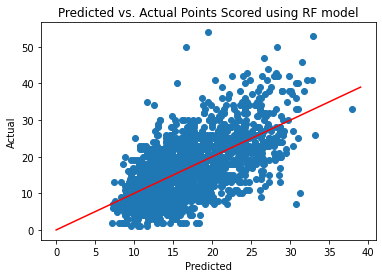

In [397]:
tree = RandomForestRegressor(max_depth=15, max_features=5, n_estimators=200, random_state=0)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_score_tree = tree.score(X_test,y_test)
print('RF score: {}'.format(y_score_tree))
_ = plt.scatter(y_pred_tree, y_test)
_ = plt.plot(np.arange(40), np.arange(40),'r')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual Points Scored using RF model')

In [398]:
pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]

USG%_player_season_AVG    0.048739
FGA_player_season_AVG     0.045607
PTS_player_season_AVG     0.044303
FG_player_season_AVG      0.043530
FGA                       0.035361
USG%                      0.034094
PTS_player_week_AVG       0.032235
FTA_player_season_AVG     0.026472
FT_player_season_AVG      0.025169
FG                        0.024759
TOV_player_season_AVG     0.020852
AST%_player_season_AVG    0.014239
min_player_season_AVG     0.013687
FT                        0.013139
BPM_player_season_AVG     0.012251
FTA                       0.011786
AST_player_season_AVG     0.011247
min                       0.010903
TOV                       0.010604
3PAr_player_season_AVG    0.010394
dtype: float64

### Lasso/Ridge

In [399]:
ridge = Ridge()
lasso = Lasso(max_iter=100000)
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_ridge = GridSearchCV(ridge, param_grid=params, scoring='r2', cv=5)
grid_lasso = GridSearchCV(lasso, param_grid=params, scoring='r2', cv=5)

#grid_ridge.fit(X_train, y_train)
#grid_lasso.fit(X_train, y_train)

#print('Best ridge params: {}'.format(grid_ridge.best_estimator_))
#print('Best lasso params: {}'.format(grid_lasso.best_estimator_))

In [400]:
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_score_ridge = ridge.score(X_test,y_test)
print('ridge score: {}'.format(y_score_ridge))

lasso = Lasso(alpha=0.1, max_iter=100000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
y_score_lasso = lasso.score(X_test,y_test)
print('lasso score: {}'.format(y_score_lasso))

ridge score: 0.40169949462852217
lasso score: 0.4038985070028063


In [402]:
coef = lasso.coef_
coef = pd.Series(coef, index=df_model.drop(columns=['PTS'], axis=1).columns).sort_values(ascending=False)
coef = coef[coef!=0]
coef

PTS_player_season_AVG          2.197685
FGA_player_season_AVG          1.584311
FT_player_season_AVG           0.696106
USG%                           0.579371
FGA                            0.394008
DRB                            0.252940
team_Pace_opp_week_AVG         0.176459
TOV                            0.172404
team_eFG%_player_season_AVG    0.109180
FT                             0.047707
team_FT/FG_opp_week_AVG        0.025375
team_ORtg_opp_week_AVG         0.025040
FG                             0.014750
team_Pace_opp_season_AVG       0.004087
USG%_player_season_AVG         0.001160
opp_Pace_opp_week_AVG          0.000598
team_FT/FG_opp_season_AVG      0.000461
opp_Pace_opp_season_AVG        0.000040
opp_TOV%_opp_season_AVG       -0.000698
opp_TOV%                      -0.018420
opp_eFG%_player_season_AVG    -0.023046
ORtg                          -0.034646
opp_TOV%_opp_week_AVG         -0.037148
ORB                           -0.041170
dtype: float64

These features are those with non-zero weights according to the best Lasso regresion model.  This provides interpretability for understanding the features that have the greatest effect towards predicting the number of points scored.  Not surprisingly, the most important features are season averages for a players points, field goals, and free throws. Usage rate averaged over the last week is also important.  If a player's usage rate is higher recently, he is likely to score more points that the season points average would suggest. Interestingly, a number of features regarding the opponent are important also.  These features typically correspond to the opponents advanced metrics, which give a more holistic description of the opponent's performance.  This suggests that a player's stats will vary against opponents with different styles and skill.  Note that I tested models with this reduced feature set (not shown) and did not see a meaningful effect on accuracy so it is not included in this notebook.

### Voting Regressor

Voting Regressor score: 0.40923840555980473


Text(0, 0.5, 'Actual')

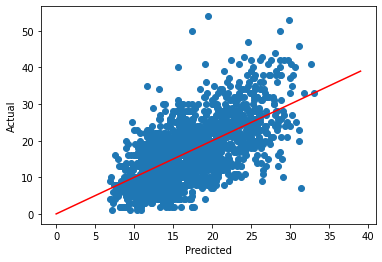

In [313]:
vote = VotingRegressor([('Ridge',ridge), ('Lasso',lasso), ('RF',tree)], n_jobs=-1)
vote.fit(X_train, y_train)
print('Voting Regressor score: {}'.format(vote.score(X_test, y_test)))
y_pred_vote = vote.predict(X_test)
_ = plt.scatter(y_pred_vote, y_test)
_ = plt.plot(np.arange(40), np.arange(40), 'r')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### Determine mean, standard deviation of normal distribution of the difference between predicted and actual points scored on the test set

Median: -0.5657736445118271
Mean: -0.1980460099243802
Standard Deviation: 6.470224367856364


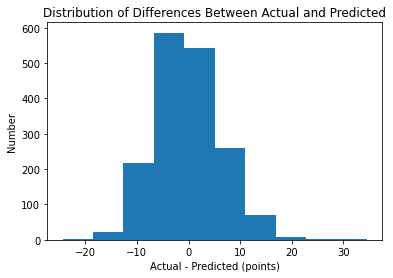

In [314]:
y_diff = y_test - y_pred_vote
_ = plt.hist(y_diff)
plt.xlabel('Actual - Predicted (points)')
plt.ylabel('Number')
plt.title('Distribution of Differences Between Actual and Predicted')

std = st.stats.tstd(y_diff)
mean = np.mean(y_diff)
median = np.median(y_diff)
print('Median: {}'.format(median))
print('Mean: {}'.format(mean))
print('Standard Deviation: {}'.format(std))

# Create data to predict during NBA playoffs
- this function will take information about a player for a particular game and output a prediction using the second model to compare to a over/under generated by a betting site

In [315]:
def predict_player_points(player, team, opp, home, date):
    X_predict = pd.DataFrame(np.array([date, team, home, opp]).reshape(1,-1), columns = ['date', 'team', 'home', 'opp'])
    
    # add player stats averaged over the last week
    df_player = df_clean[df_clean['player_name'] == player]
    df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_player_week = df_player_week.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).mean()
    df_player_week = pd.DataFrame(np.array(df_player_week).reshape(1,-1), columns = df_player_week.index)
    
    
    # add player stats averaged over the season
    df_player_season = df_player[df_player['date'] < date]
    df_player_season = df_player_season.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).mean()
    df_player_season = pd.DataFrame(np.array(df_player_season).reshape(1,-1), columns = df_player_season.index)
    
    # add opponent stats averaged over the last week
    df_opp = df_clean[df_clean['team_name'] == opp]
    df_opp = df_opp[['date','team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg', 
                     'opp_Pace', 'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg']]
    df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_opp_week = df_opp_week.groupby(by='date').agg(np.mean)
    df_opp_week = df_opp_week.mean()
    df_opp_week = pd.DataFrame(np.array(df_opp_week).reshape(1,-1), columns = df_opp_week.index)
        
    # add opponent stats averaged over the season
    df_opp_season = df_opp[df_opp['date'] < date]
    df_opp_season = df_opp_season.groupby(by='date').agg(np.mean)
    df_opp_season = df_opp_season.mean()
    df_opp_season = pd.DataFrame(np.array(df_opp_season).reshape(1,-1), columns = df_opp_season.index)

    # merge all three df's
    X_predict = pd.merge(X_predict, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_player_week_AVG'))
    X_predict = pd.merge(X_predict, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_player_season_AVG'))
    X_predict = pd.merge(X_predict, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_opp_week_AVG'))
    X_predict = pd.merge(X_predict, df_opp_season, how='inner', left_index=True, right_index=True, suffixes=('','_opp_season_AVG'))
    # drop team and opp
    X_predict.drop(columns=['date','team','opp'], axis=1, inplace=True)

    for col in X_predict.columns:
        if X_predict[col].isnull().sum() == len(X_predict):
            X_predict.drop(columns=[col], axis=1, inplace=True)
            
    X_predict = scale.transform(X_predict)
    y_pred = np.round(vote.predict(X_predict), 1)
    return y_pred[0]
    

# Main
### enter game info and write all data to excel file

In [340]:
# enter game info
name1 = 'Devin Booker'  # home player
OU1 = 28.5
name2 = 'LeBron James' # road player
OU2 = 24.5
bet_id = 16
playoff_round = 1
game = 2


date = pd.to_datetime('2021-05-25')

########
team1 = df_players[df_players['player_name'] == name1]['team_name'].values[0]
team2 = df_players[df_players['player_name'] == name2]['team_name'].values[0]

pred1 = predict_player_points(name1, team1, team2, 1, date)
pred2 = predict_player_points(name2, team2, team1, 0, date)

diff1 = OU1 - pred1
diff2 = OU2 - pred2

####### determine probability of success for bets on first model
if diff1 > 0:
    p1 = st.norm(mean,std).cdf(diff1)
else:
    p1 = 1 - st.norm(mean,std).cdf(diff1)
    
if diff2 > 0:
    p2 = st.norm(mean,std).cdf(diff2)
else:
    p2 = 1 - st.norm(mean,std).cdf(diff2)
    
p = p1 * p2
if p > 0.33:
    bet = round(800*p**4, 2)
else:
    bet = 0

####### determine whether to bet over or under
if OU1-pred1 > 0:
    OU1_bet = 0
else:
    OU1_bet = 1

if OU2-pred2 > 0:
    OU2_bet = 0
else:
    OU2_bet = 1

# format everything into a row of the excel file
New_row_1 = np.array([name1, team1, team2, 1, playoff_round, game, pred1, OU1, np.round(OU1-pred1, 3), 
                      np.round(p1, 3), bet, bet_id, OU1_bet, '?', '?', '?', '?', '?'])
New_row_2 = np.array([name2, team2, team1, 0, playoff_round, game, pred2, OU2, np.round(OU2-pred2, 3), 
                      np.round(p2, 3), bet, bet_id, OU2_bet, '?', '?', '?', '?', '?'])

New_rows = np.concatenate((New_row_1.reshape(1,-1), New_row_2.reshape(1,-1)), axis=0)

columns = ['Player', 'Team', 'Opp', 'Home', 'Round', 'Game', 'Prediction', 'O/U', 'Line Diff', 'Prob',
           'Wager', 'Bet ID', 'O/U bet','Actual', 'Diff', 'Correct', 'Win', 'Money'
          ]
df_rows = pd.DataFrame(New_rows, columns = columns)

######## write the two rows into the excel file
writer = pd.ExcelWriter('Playoff_prop_bets.xlsx', engine='openpyxl')
# try to open an existing workbook
writer.book = load_workbook('Playoff_prop_bets.xlsx')
# copy existing sheets
writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
# read existing file
reader = pd.read_excel(r'Playoff_prop_bets.xlsx')
# write out the new sheet
df_rows.to_excel(writer,index=False,header=False,startrow=len(reader)+1)
writer.close()

### Predict one player

In [123]:
player = 'Bradley Beal'
team = df_players[df_players['player_name'] == player]['team_name'].values[0]
opp = 'Philadelphia 76ers'
home = 1
date = pd.to_datetime('2021-05-20')
predict_player_points(player, team, opp, home, date)

30.2

In [115]:
df_players[df_players['player_name'] == player]['team_name'].values[0]

'Utah Jazz'

# Accuracy vs. Over/Under lines set by monkeyknifefight.com

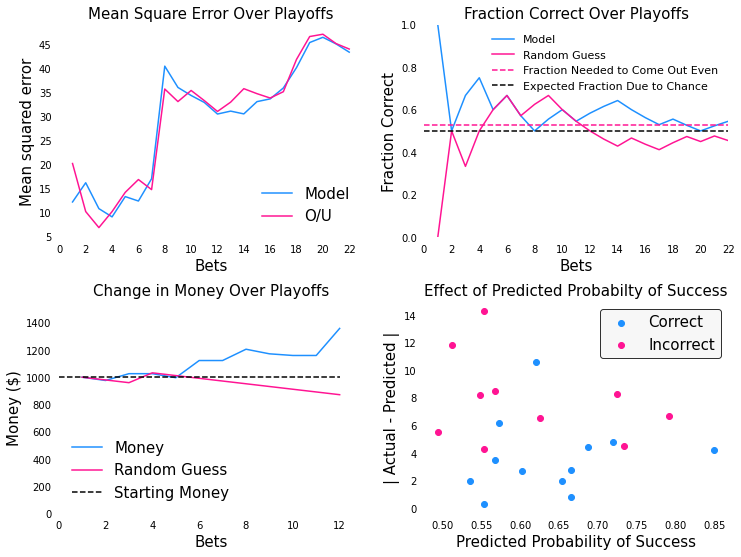

In [348]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize=(12,9))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

data = pd.read_csv('Playoff_prop_bets.csv')

# get rid of rows for games that haven't happened yet
data = data[data['Money'] != '?']

# convert relevant columns to numeric data type
numeric = ['Actual', 'Diff', 'Correct', 'Win', 'Money']
for col in numeric:
    data[col] = pd.to_numeric(data[col])

###################################################################################### Figure One
# plot difference from actual for model prediction vs. over/under line
diff_model = data['Diff']
diff_OU = data['Actual'] - data['O/U']

mse_model = diff_model**2
mse_OU = diff_OU**2

cum_mse_model = []
cum_mse_OU = []
for i in range(len(mse_OU)):
    cum_mse_model.append(mse_model[:i+1].sum()/(i+1))
    cum_mse_OU.append(mse_OU[:i+1].sum()/(i+1))

ax1.plot(np.arange(len(mse_OU))+1, cum_mse_model, c='dodgerblue', label='Model')
ax1.plot(np.arange(len(mse_OU))+1, cum_mse_OU, c='deeppink', label='O/U')

ax1.set_xlabel('Bets', fontsize=15)
ax1.set_ylabel('Mean squared error', fontsize=15)
ax1.set_title('Mean Square Error Over Playoffs', fontsize=15)
ax1.legend(frameon=False, fontsize=15)
ax1.tick_params(bottom=False, left=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_xticks(np.arange(0, len(data)+1, 2))

###################################################################################### Figure Two
# plot percent correct over time
correct = data['Correct']
guess = np.random.randint(2, size=len(correct))

cumulative_correct = []
cumulative_guess = []
for i in range(len(correct)):
    cum_correct = correct[:i+1].sum()
    cum_guess = guess[:i+1].sum()
    cumulative_correct.append(cum_correct/(i+1))
    cumulative_guess.append(cum_guess/(i+1))

ax2.plot(np.arange(len(cumulative))+1, cumulative_correct, c='dodgerblue', label='Model')
ax2.plot(np.arange(len(cumulative))+1, cumulative_guess, c='deeppink', label = 'Random Guess')
ax2.plot([0, len(cumulative)], [np.sqrt(1/3.6), np.sqrt(1/3.6)], '--', c='deeppink', label='Fraction Needed to Come Out Even')
ax2.plot([0, len(cumulative)], [0.5, 0.5], '--', c='black', label='Expected Fraction Due to Chance')

ax2.axis([0, len(cumulative), 0, 1])
ax2.set_xlabel('Bets', fontsize=15)
ax2.set_ylabel('Fraction Correct', fontsize=15)
ax2.set_title('Fraction Correct Over Playoffs', fontsize=15)
ax2.legend(frameon=False, fontsize=11, loc='best')
ax2.tick_params(bottom=False, left=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)
ax2.set_xticks(np.arange(0, len(data)+1, 2))

###################################################################################### Figure Three
Money = np.array([1000])
Money = np.append(Money, data.groupby(by='Bet ID')['Money'].agg(np.mean).values)

data['random guess'] = guess
guess = data.groupby(by='Bet ID')['random guess'].agg(np.sum)
money_guess = [1000]
wager = 20
for value in guess:
    if value == 2:
        money_guess.append(money_guess[-1] + 3.6*wager)
    else:
        money_guess.append(money_guess[-1] - wager)

ax3.plot(np.arange(len(Money))+1, Money, c='dodgerblue', label='Money')
ax3.plot(np.arange(len(Money))+1, money_guess, c='deeppink', label='Random Guess')
ax3.plot([0,len(Money)], [1000, 1000], '--', c='black', label='Starting Money')

ax3.axis([0, len(Money)+1, 0, np.max(Money)+200])
ax3.set_xlabel('Bets', fontsize=15)
ax3.set_ylabel('Money ($)', fontsize=15)
ax3.set_title('Change in Money Over Playoffs', fontsize=15)
ax3.legend(frameon=False, fontsize=15)
ax3.tick_params(bottom=False, left=False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.tick_params(axis='x', labelsize=10)
ax3.tick_params(axis='y', labelsize=10)

###################################################################################### Figure Four
correct = data[data['Correct'] == 1]
incorrect = data[data['Correct'] == 0]

ax4.scatter(correct['Prob'], np.abs(correct['Diff']), c='dodgerblue', label='Correct')
ax4.scatter(incorrect['Prob'], np.abs(incorrect['Diff']), c='deeppink', label='Incorrect')

ax4.set_xlabel('Predicted Probability of Success', fontsize=15)
ax4.set_ylabel('| Actual - Predicted |', fontsize=15)
ax4.set_title('Effect of Predicted Probabilty of Success', fontsize=15)
ax4.legend(edgecolor='black', facecolor='whitesmoke', fontsize=15)
ax4.tick_params(bottom=False, left=False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.tick_params(axis='x', labelsize=10)
ax4.tick_params(axis='y', labelsize=10)